# Transforms and Multi-Table Relational Databases
* This notebook shows how to run transforms directly on a mutli-table relational database while keeping the referential integrity of primary and foreign keys intact.
* This notebook also contains instructions on how to transform data residing in CSV files.

## Our ecommerce database
* Execute the below cell to see a diagram of the database we'll be using in this blueprint. The lines in the diagram show connections between primary and foreign keys

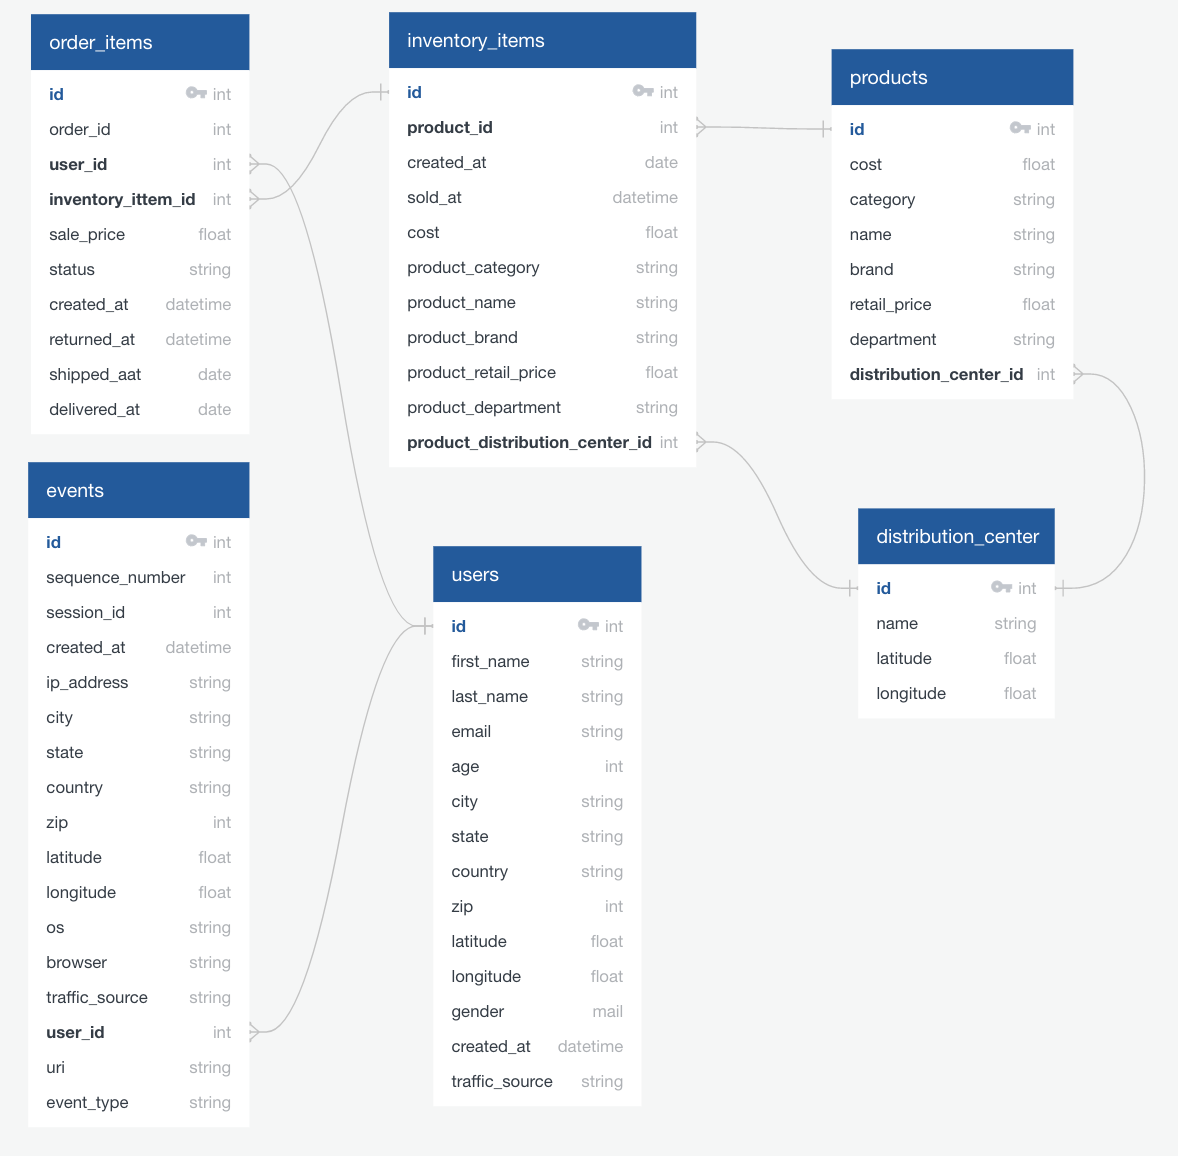

In [1]:
from IPython.display import Image
Image("https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/rdb/ecommerce_db.png",width = 600, height = 600)

## Getting started

In [ ]:
!pip install pyyaml Faker pandas
!pip install SQLAlchemy
!pip install -U gretel-client

In [2]:
# Specify your Gretel API key

from getpass import getpass
import pandas as pd
from gretel_client import configure_session, ClientConfig

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api-dev.gretel.cloud"))

/Users/amysteier/Documents/GitHub/monogretel/python/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Enter Gretel API key········


## Gather data and schema relationships directly from a database
* For demonstration purposes, we'll first grab our ecommerce SQLite database from S3
* This notebook can be run on any database SQLAlchemy supports such as Postgresql or MySQL
* For example, if you have a postgres database, simply swap the `sqlite:///` connection string for a `postgres://` one in the `create_engine` command
* Using SQLAlchemy's reflection extension, we will crawl the schema, gather table data and produce a list of relationships by table primary key.

In [3]:
from sqlalchemy import create_engine

!wget https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom.db
    
engine = create_engine("sqlite:///ecom.db")

--2022-04-04 14:17:52--  https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom.db
Resolving gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)... 52.92.147.161
Connecting to gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)|52.92.147.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16879616 (16M) [binary/octet-stream]
Saving to: ‘ecom.db.2’

ecom.db.2           100%[===================>]  16.10M  8.53MB/s    in 1.9s    

2022-04-04 14:17:54 (8.53 MB/s) - ‘ecom.db.2’ saved [16879616/16879616]



In [4]:
# Gather the table data from the database

from sqlalchemy import MetaData, text

# This is the directory where we will temporarily store csv files for the transformer model
base_path = "./"

metadata = MetaData()
metadata.reflect(engine)

rdb_config = {}
rdb_config["table_data"] = {}
rdb_config["table_files"] = {}

for name, table in metadata.tables.items():
    df = pd.read_sql_table(name, engine)
    rdb_config["table_data"][name] = df
    filename = name + ".csv"
    df.to_csv(filename, index=False, header=True)
    rdb_config["table_files"][name] = filename


In [5]:
# Extract primary/foriegn key relationshihps

from collections import defaultdict

rels_by_pkey = defaultdict(list)

for name, table in metadata.tables.items():
    for col in table.columns:
        for f_key in col.foreign_keys:
            rels_by_pkey[(f_key.column.table.name, f_key.column.name)].append((name, col.name))

list_of_rels_by_pkey = []

for p_key, f_keys in rels_by_pkey.items():
    list_of_rels_by_pkey.append([p_key] + f_keys)

rdb_config["relationships"] = list_of_rels_by_pkey

## Alternatively, specify primary/foreign key relationships and locations of data csv files 
* This is an alternative to the above three cells that work directly with a database
* First, assign `base_path` to the directory where the csv files are located.
* Then, add a name/key pair for each table name/filename to `rdb_config["table_files"]`
* Add all foreign key/primary keys that connect to the same set under `rdb_config["relationshipts"]`

In [ ]:
# base_path is the directory where your csv files can be found
base_path = "https://gretel-blueprints-pub.s3.amazonaws.com/rdb/"

rdb_config = {
   "table_files": {
      "users": "users.csv",

      "order_items": "order_items.csv",
       
      "events": "events.csv",
       
      "inventory_items": "inventory_items.csv",  
       
      "products": "products.csv",
       
      "distribution_center": "distribution_center.csv"
   },

  # List the (table, field) relationships between primary and foreign keys  
   "relationships": [
          {("users","id"),
           ("order_items","user_id"),
           ("events","user_id")
          },         
       
          {("inventory_items","id"),
           ("order_items","inventory_item_id")  
          },         

          {("products","id"),
           ("inventory_items","product_id")
          },                

          {("distribution_center","id"),
           ("products","distribution_center_id"),
           ("inventory_items", "product_distribution_center_id")
          }             
   ]
}

# Gather the table data using the filenames entered above

rdb_config["table_data"] = {}
for table in rdb_config["table_files"]:
    filename = base_path + rdb_config["table_files"][table]
    df = pd.read_csv(filename)
    rdb_config["table_data"][table] = df

## Take a look at your data by joining two tables
* Note that every record in the table "order_items" matches to an entry in the table "users"

In [14]:
table_to_view1 = "order_items"
table_to_view2 = "users"
df1 = rdb_config["table_data"][table_to_view1]
df2 = rdb_config["table_data"][table_to_view2]

joined_data = df1.join(df2.set_index('id'), how='inner', on='user_id', lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

show_fields = ['id', 'user_id', 'inventory_item_id', 'sale_price', 'shipped_at', 'delivered_at', 'first_name', 'last_name', 'age', 'latitude', 'longitude']
joined_data.filter(show_fields).head()

Number of records in order_items table is 7882
Number of records in user table is 2197
Number of records in joined data is 7882


,id,user_id,inventory_item_id,sale_price,shipped_at,delivered_at,first_name,last_name,age,latitude,longitude
0,11029,10751,11029,8.00,None,None,BOBBY,FLEMING,43,31.835673,-110.028364
1830,124866,10751,135867,9.99,2018-07-06,2018-07-10,BOBBY,FLEMING,43,31.835673,-110.028364
3735,175885,10751,186886,64.00,2018-09-14,2018-09-17,BOBBY,FLEMING,43,31.835673,-110.028364
1,11918,11609,11918,25.00,None,None,ABBIE,STONE,16,33.272891,-112.183915
1451,234261,11609,245262,9.54,2019-03-05,2019-03-10,ABBIE,STONE,16,33.272891,-112.183915


## Define your transform policies
* Define one policy per table which transforms any PII or sensitive information that could be used to reidentify a user.
* Do not include a transform for any of the primary/foreign key combinations. We'll be handling those seperately in order to maintain referential integrity.
* However, if a table contains a primary key that does not match to a foreign key, that field should be included in the transforms.
* Note the tables inventory_items, products and distribution center contain only public information so there will be no transformation.
* To run this notebook on a different database, simply enter the table names and policy files below. We will assume all policy files are located in the `policy_dir` defined below

In [7]:
policy_dir = "https://gretel-blueprints-pub.s3.amazonaws.com/rdb/"

transform_policies = {}
transform_policies["users"] = "users_policy.yaml"
transform_policies["order_items"] = "order_items_policy.yaml"
transform_policies["events"] = "events_policy.yaml"
transform_policies["inventory_items"] =  None  
transform_policies["products"] = None
transform_policies["distribution_center"] = None

## Policy detail
* Let's take a detailed look at the transforms for the users table.
* Within the `rules` section, we define each type of transformation we want, each one beginning with `- name`.
* We start by replacing any field classified as a person name or email address with a fake version.
* Note, we choose to leave "city", "state", "country" and "zip" as is since it's public knowledge that this database is about user ecommerce transactions in Arizona.
* We then transform the "created_at" timestamp using a random date shift.
* And finally, we transform the numeric fields of age, latitude and longitude with a random numeric shift.
* Note, we do not transform "id" because it is a primary key that matches to a foreign key. We'll take care of that later.

In [8]:
from smart_open import open

policy_file = transform_policies["users"]
policy_file_path = policy_dir + policy_file
yaml_file = open(policy_file_path, "r")
policy = yaml_file.read()
yaml_file.close()
print(policy)

schema_version: "1.0"
name: "users_transforms"
models:
  - transforms:
      data_source: "_"
      use_nlp: false
      policies:
        - name: users_transform
          rules:
            - name: fake_names_and_email
              conditions:
                field_label:
                  - person_name
                  - email_address
              transforms:
                - type: fake
            - name: date_shift
              conditions:
                field_name:
                  - created_at
              transforms:
                - type: dateshift
                  attrs:
                    min: -400 
                    max: 65 
                    formats: '%Y-%m-%d %H:%M:%S UTC' 
            - name: numeric_shifts
              conditions:
                field_name:
                  - age
                  - latitude
                  - longitude
              transforms:
                - type: numbershift
                  attrs:
                    min: 10
 

## Define functions to train models and generate transformed data

In [9]:
import yaml
import numpy as np
from smart_open import open
from sklearn import preprocessing
from gretel_client import create_project
from gretel_client.helpers import poll

def create_model(table:str, project):

    # Read in the transform policy
    policy_file = transform_policies[table]
    policy_file_path = policy_dir + policy_file
    yaml_file = open(policy_file_path, "r")
    policy = yaml_file.read()
    yaml_file.close()

    # Get the dataset_file_path
    dataset_file = rdb_config["table_files"][table]
    dataset_file_path = base_path + dataset_file

    # Create the transform model
    model = project.create_model_obj(model_config=yaml.safe_load(policy))
    
    # Upload the training data.  Train the model.
    model.data_source = dataset_file_path
    model.submit(upload_data_source=True)
    print("Model training started for " + table)
    
    return model
 
def generate_data(table:str, model):
    
    record_handler = model.create_record_handler_obj()
    
    # Get the dataset_file_path
    dataset_file = rdb_config["table_files"][table]
    dataset_file_path = base_path + dataset_file

    # Submit the generation job
    record_handler.submit(
        action = "transform",
        data_source = dataset_file_path,
        upload_data_source = True
        )
    
    print("Generation started for " + table)
    
    return record_handler    
        

## Set off training and generation and monitor progress
* Note, jobs will be set off in parallel then we will monitor them until completion

In [10]:
# Initiate model training and generation

import pandas as pd

# model_progress will hold the status of each model during training and generation
model_progress = {}

# transformed_tables will hold the final transformed tables
transformed_tables = {}

# Create a new project
project = create_project(display_name="rdb_transform3")

for table in rdb_config["table_files"]:
    if transform_policies[table] is not None:
        model = create_model(table, project)
        model_progress[table] = {
                         "model": model,
                         "model_status": "pending",
                         "record_handler": "",
                         "record_handler_status": "",
                         } 
    # If there is no transform on a table, copy it over as is
    else:
        transformed_tables[table] = rdb_config["table_data"][table]
        
        
# Monitor model progression

more_to_do = True
while more_to_do:
    
    # Check status of training
    more_to_do = False
    for table in model_progress:
        status = model_progress[table]["model_status"]
        if (status == 'created') or (status == 'pending') or (status == "active"):
            more_to_do = True
            model = model_progress[table]["model"]
            model._poll_job_endpoint()
            status = model.__dict__['_data']['model']['status']
            
            # If status is now complete, submit the generation job
            if status == 'completed':
                print("Training completed for " + table)
                rh = generate_data(table, model)
                model_progress[table]["record_handler"] = rh
                model_progress[table]["record_handler_status"] = "pending"
                    
            model_progress[table]["model_status"] = status
                
        # If training status was already complete, check status of the generation job
        elif status == 'completed':
            
            status = model_progress[table]["record_handler_status"]
            if (status == 'created') or (status == 'pending') or (status == 'active'):
            
                rh = model_progress[table]["record_handler"]
                rh._poll_job_endpoint()
                status = rh.__dict__['_data']['handler']['status']
                
                # If generation is now complete, get the synthetic data
                if status == 'completed':
                    transform_df = pd.read_csv(rh.get_artifact_link("data"), compression='gzip')
                    transformed_tables[table] = transform_df
                    model_progress[table]["record_handler_status"] = status
                    print("Generation completed for " + table)
                    
                elif status != 'error':
                    more_to_do = True
                
                else:
                    print("\nGeneration for " + table + " ended in error")
                    more_to_do = False
                    
            model_progress[table]["record_handler_status"] = status
                
        elif status == 'error':
            print("\nTraining for " + table + " ended in error")
            model_progress[table]["model_status"] = status
            more_to_do = False

if status != 'error':
    print("\nModel training and initial generation all complete!")


Model training started for events
Model training started for order_items
Model training started for users
Training completed for users
Generation started for users
Generation completed for users
Training completed for order_items
Generation started for order_items
Training completed for events
Generation started for events
Generation completed for order_items
Generation completed for events

Model training and initial generation all complete!


## Transform primary/foreign key combinations
* To ensure referential integrity on each primary key/foreign key table set, we will first fit a Label Encoder on the combined set of unique values in each table. 
* We then run the Label Encoder on the key field in each table in the set.
* This both de-identifies the keys as well as serves to ensure referential integrity.

In [11]:
def transform_keys(key_set):
    
    # Get array of unique values from each table, can use dfs in transformed_tables    
    field_values = set()
    for table_field_pair in key_set:
        table, field = table_field_pair
        field_values = field_values.union(set(transformed_tables[table][field]))
        
    # Train a label encoder
    field_values_list = list(field_values)
    le = preprocessing.LabelEncoder()
    le.fit(field_values_list)
    
    # Run the label encoder on dfs in transformed_tables
    for table_field_pair in key_set:
        table, field = table_field_pair
        transformed_tables[table][field] = le.transform(transformed_tables[table][field]) 

# Run our transform_keys function on each key set
for key_set in rdb_config["relationships"]:
    transform_keys(key_set)

## View the transformed content
* We'll again join the order_items and users tables

In [12]:
pd.set_option("display.max_columns", None)

table_to_view1 = "order_items"
table_to_view2 = "users"
df1 = transformed_tables[table_to_view1]
df2 = transformed_tables[table_to_view2]

joined_data = df1.join(df2.set_index('id'), how='inner', on='user_id', lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

show_fields = ['id', 'user_id', 'inventory_item_id', 'sale_price', 'shipped_at', 'delivered_at', 'first_name', 'last_name', 'age', 'latitude', 'longitude']
joined_data.filter(show_fields).head()

Number of records in order_items table is 7882
Number of records in user table is 2197
Number of records in joined data is 7882


,id,user_id,inventory_item_id,sale_price,shipped_at,delivered_at,first_name,last_name,age,latitude,longitude
0,20463,10751,11029,8.00,NaN,NaN,Krystal,Edwards,53,41.835673,-100.028364
1830,142230,10751,135867,9.99,2018-01-17,2018-01-21,Krystal,Edwards,53,41.835673,-100.028364
3735,272604,10751,186886,64.00,2017-11-20,2017-11-23,Krystal,Edwards,53,41.835673,-100.028364
1,108412,11609,11918,25.00,NaN,NaN,Daniel,Atkinson,26,43.272891,-102.183915
1451,250498,11609,245262,9.54,2018-10-29,2018-11-03,Daniel,Atkinson,26,43.272891,-102.183915


## Save the transformed data back into an SQLite database

In [13]:
!cp ecom.db ecom_xf.db
engine_xf = create_engine("sqlite:///ecom_xf.db")

for table in transformed_tables:
    transformed_tables[table].to_sql(table, con=engine_xf, if_exists='replace', index=False)

## Alternatively save the transformed data back into a Postgres database

In [ ]:
from sqlalchemy import text

with engine.connect() as conn:
    result = conn.execute(text("create database ecom_xf with template ecom"))
    engine_xf = create_engine("postgres:///ecom_xf.db")
    for table in transformed_tables:
      transformed_tables[table].to_sql(table, con=engine_xf, if_exists='replace', index=False)

    conn.commit()

## Alterntively, save the transformed content into CSV files

In [ ]:
# Change final_dir to be the location where you'd like your csv files saved
final_dir = "./"
for table in transformed_tables:
    df = transformed_tables[table]
    filename = final_dir + table + '_transformed.csv'
    df.to_csv(filename, index=False, header=True)